In [2]:
import numpy as np
import pandas as pd
import math as m
import matplotlib.pyplot as plt
import warnings

import scipy
from scipy.spatial import distance_matrix

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from tqdm import tqdm

from visuals import *
from my_lib import *

In [3]:
def CartesianToSpherical(point):
    r = np.sqrt(sum(point ** 2))
    n = len(point)
    phi = np.zeros(n - 1)
    
    for i in range(n - 2):
        phi[i] = np.arccos(point[i] / np.sqrt(sum(point[i:] ** 2)))
        
    if point[-1] >= 0:
        phi[n - 2] = np.arccos(point[n - 2] / np.sqrt(point[n - 1] ** 2 + point[n - 2] ** 2))
    else:
        phi[n - 2] = 2 * np.pi - np.arccos(point[n - 2] / np.sqrt(point[n - 1] ** 2 + point[n - 2] ** 2))
        
    return np.hstack((phi, r))


def TrajectoryToSpherical(tr):
    tr_spherical = np.zeros(tr.shape)
    for i, point in enumerate(tr):
        tr_spherical[i] = CartesianToSpherical(point)
    return tr_spherical


def SphericalToCartesian(point):
    phi, r = point[:-1], point[-1]
    n = len(point)
    x = np.zeros(n) 
    cur = r
    
    for i in range(n - 1):
        x[i] = cur * np.cos(phi[i])
        cur *= np.sin(phi[i])

    x[n - 1] = cur
    return x
    

def TrajectoryToCartesian(tr):
    tr_cartesian = np.zeros(tr.shape)
    for i, point in enumerate(tr):
        tr_cartesian[i] = SphericalToCartesian(point)
    return tr_cartesian

def HankelMatrix(qwe, L):  
    N = qwe.shape[0]
    return scipy.linalg.hankel(qwe[ : N - L + 1], qwe[N - L : N])

def prepare_time_series(_dir, centred = True):
    data = pd.read_csv(_dir, delimiter =';', decimal=',')
    
    frequency = len(data)/(data['time'].values[-1]-data['time'].values[0])
    
    assert 490 < frequency < 510, f'Bad frequency {frequency}'

    _x = ( (data['X_value'].values)**2 + (data['Y_value'].values)**2 + (data['Z_value'].values)**2)**.5
    
    if centred:
        _m = np.mean(_x)
        _x = (_x-_m)
        
    _t = (data['time'].values).astype(float).reshape([-1,])

    _t = np.linspace(0,_t[-1]-_t[0],len(_x))
        
    return _x,_t

In [4]:
class NWregression():

    def __init__(self, h, kernel = 'gaussian', metric = 'l2', gamma = 2):
        kernels = {
            'gaussian': self._gaussian_kernel,
            'rectangular': self._rectangular_kernel,
            'triangular': self._triangular_kernel,
            'quadratic': self._quadratic_kernel,
            'quartic': self._quartic_kernel
        }
        self.h = h
        self.gamma = gamma
        self.metric = metric
        self.kernel = kernels[kernel]
        
    def _gaussian_kernel(self, r):
        return np.exp(-self.gamma*r**2)
    
    def _rectangular_kernel(self, r):
        return r * (r < 1)

    def _triangular_kernel(self, r):
        return (1-r) * (r < 1)

    def _quadratic_kernel(self, r):
        return (1-r**2) * (r < 1)

    def _quartic_kernel(self, r):
        return (1-r**2)**2 * (r < 1)
    
    def fit(self, X, Y):
        self.X = X
        self.Y = Y
        return self

    def predict(self, X):
        
        dist_matrix = pairwise_distances(X,self.X, metric = self.metric)
        
        weight = self.kernel(dist_matrix/self.h)
        
        norm_coef = np.sum(weight,axis=1).reshape((len(X),1))
        
        regression_ans = (weight@self.Y)/norm_coef
        
        return regression_ans

In [5]:
x_acc_test, t_test = prepare_time_series('./data/30 sec 2_accm.csv')

x_acc, t = prepare_time_series('./data/long_walk_100_acc.csv')

n_steps = 20
T = 462

dt = T * n_steps

x_acc = x_acc[7174:7174+dt]
fig = go.Figure()
fig.add_scatter(y = x_acc[:], mode='lines', name='x_acc')
fig.show()

In [6]:
X_h = HankelMatrix(x_acc, 500)

pca = PCA(n_components = 4)
X_PCA = pca.fit_transform(X_h)

X = np.linspace(0, 2*np.pi * (n_steps - 1), len(X_PCA))%(2*np.pi)
X = X.reshape((len(X),1))
Y = X_PCA
X_mean = np.linspace(0,2*np.pi,900).reshape((900,1))

metric = lambda x,y: 1 - np.cos(x-y)

model = NWregression(h = 0.03, kernel = 'gaussian', metric = metric)
model.fit(X,Y)
regression = model.predict(X_mean)

In [7]:
fig = go.Figure()
fig.update_layout(autosize=False, width=700, height=700)
fig.add_trace(go.Scatter3d(x=Y[:,0],
                           y=Y[:,1],
                           z=Y[:,2],
                           marker=dict(size=0.1,line=dict(width=0.01)),
                           name = 'X_PCA'
                          )
             )
fig.add_trace(go.Scatter3d(x=regression[:,0],
                           y=regression[:,1],
                           z=regression[:,2],
                           marker=dict(size=0.1,line=dict(width=0.01)),
                           name = 'Mean'
                            )
                )
fig.layout.template = 'plotly_white'
fig.show()

In [8]:
X_temp = np.linspace(0,2*np.pi,T).reshape((T,1))
regression_for_loss = model.predict(X_temp)

dX = np.zeros_like(X_PCA)
for i in range(1,n_steps-2):
    dX[T*(i):T*(i+1)] = X_PCA[T*(i):T*(i+1)] - regression_for_loss

KeyboardInterrupt: 

In [ ]:
import statsmodels.api as sm
import scipy.stats
from scipy import stats

In [ ]:
res = dX[:,0]

In [ ]:
table_hypothesis = pd.DataFrame([['Нормальность', 'Шапиро-Уилка', 'отвергается', stats.shapiro(res)[1]],
                     ['Несмещённость', 'Уилкоксона', 'не отвергается', stats.wilcoxon(res)[1]],
                     ['Стационарность', 'KPSS', 'не отвергается', sm.tsa.stattools.kpss(res)[1]]])
table_hypothesis.columns = ['Гипотеза', 'Критерий', 'Результат проверки','Достигаемый уровень значимости']
table_hypothesis

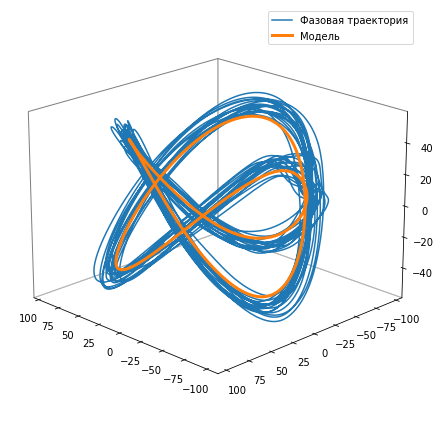

In [12]:
#поворот для отрисовки
Y_ = Y[:,:3]
regression_ = regression[:,:3]
a = -30/180 * np.pi

T_X = np.array([[1,0,0],
                [0,np.cos(a),-np.sin(a)],
                [0,np.sin(a),np.cos(a)]])

T_Y = np.array([[np.cos(a),-np.sin(a),0],
                [np.sin(a),np.cos(a),0],
                [0,0,1]])

T_Z = np.array([[np.cos(a),0,np.sin(a)],
                [0,1,0],
                [-np.sin(a),0,np.cos(a)]])

Y_ = Y_@T_Y
regression_ = regression_@T_Y

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')

ax.plot(Y_[:,0],
        Y_[:,1],
        Y_[:,2],
        label='Фазовая траектория')

ax.plot(regression_[:,0],
        regression_[:,1],
        regression_[:,2],
        label='Модель',
        lw = 3)

ax.xaxis.set_rotate_label(False)
ax.yaxis.set_rotate_label(False)
ax.zaxis.set_rotate_label(False)
ax.view_init(elev=20, azim=135)

ax.grid(False)
ax.xaxis.pane.set_edgecolor('black')
ax.yaxis.pane.set_edgecolor('black')
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
plt.legend()
fig.tight_layout()
fig.savefig('st2.png',
#             format='eps',
            dpi=600,
           bbox_inches='tight')
plt.show()

In [35]:
D_init = np.min(distance_matrix(X_PCA, regression, p = 1),axis = 1).reshape((len(X_PCA),1))
model_D = NWregression(h = .03)
model_D.fit(X,D_init)
regression_D = model_D.predict(X_mean)

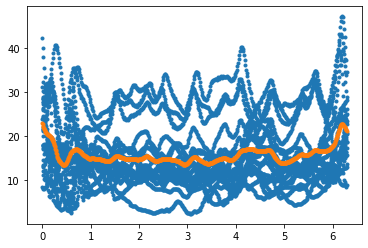

In [36]:
plt.plot(X,D_init,'.')
plt.plot(X_mean,regression_D,'.')
plt.show()

In [37]:
D = np.mean(D_init)
D

15.745523281817825

___

In [196]:
X_h = HankelMatrix(x_acc, 500)
pca = PCA(n_components = 10)
X_PCA = pca.fit_transform(X_h)[:3000]
X_SP = TrajectoryToSpherical(X_PCA)

In [136]:
x = np.linspace(np.min(X_PCA[:,0]), np.max(X_PCA[:,0]),100).reshape((100,1))

In [168]:
model_temp = NWregression(h = 10, kernel = 'gaussian', metric = 'l2', gamma = 4)
X = X_PCA[:,:2]#.reshape((len(X_PCA),1))
Y = X_PCA[:,2:]
model_temp.fit(X,Y)

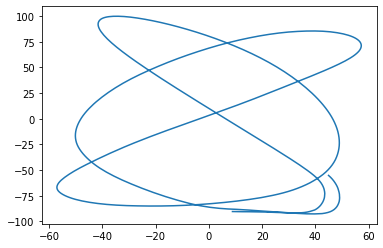

In [103]:
plt.plot(X[:500,:],Y[:500,0])

In [174]:
np.max(X,axis = 0), np.min(X,axis = 0)

(array([99.79564235, 92.38976055]), array([-92.6858082 , -87.13276278]))

In [169]:
Y_pred = model_temp.predict(X)

In [ ]:
x_0 = np.linspace(np.min(X_PCA[:,:0]),np.max(X_PCA[:,:1]), 100)
x_1 =
np.meshgrid(x, y)

In [170]:
fig = go.Figure()
fig.update_layout(autosize=False, width=700, height=700)
fig.add_trace(go.Scatter3d(x=X_PCA[:,0],
                           y=X_PCA[:,1],
                           z=X_PCA[:,2],
                           marker=dict(size=0.1,line=dict(width=0.01)),
                           name = 'X_PCA'
                          )
             )
fig.add_trace(go.Scatter3d(x=X[:,0],
                           y=X[:,1],
                           z=Y_pred[:,0],
                           marker=dict(size=0.1,line=dict(width=0.01)),
                           name = 'Mean'
                            )
                )
fig.layout.template = 'plotly_white'
fig.show()